In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
import random
import statistics as st #for the mode
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
#repeated measures correlation
import pingouin as pg

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, AgostinosK2Test, ShapiroTest
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


2


C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))

131


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#dailyMVT var
df_MVT = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed_SNA_clID.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT.shape)
df_MVT = df_MVT[~df_MVT['DOA'].isnull()] #TODO: check where this comes from
print(df_MVT.shape)
df_MVT['DIB'] = df_MVT['DOA'].map(lambda x: x-118)
df_MVT['WOA'] = df_MVT['DOA'].map(lambda x: math.ceil(x/7))
df_MVT = df_MVT[df_MVT['HenID'].isin(li_selected_hens)]
#lets restrict to the adaptability study timeframe
df_MVT = df_MVT[df_MVT['level']<=config.max_date_adaptability]
print(df_MVT.shape)
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (123,135,172,173,174,175,176,177,179,180,181,182,183,184,185,186,187,188) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(42300, 223)
(42099, 223)
(6721, 224)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,degree_DTW_30_1_Zone,degree_DTW_30_2_Zone,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40,DIB
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,1.000000,0.131944,0.208333,0.826389,0.437500,0.312500,NaN,NaN,NaN,1.0
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.993197,0.047619,0.176871,0.802721,0.115646,0.380952,NaN,NaN,NaN,2.0
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,1.000000,0.564626,0.646259,0.802721,0.455782,0.503401,NaN,NaN,NaN,3.0


# Processing

In [8]:
#print(list(df_MVT.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#more than a zone
df_MVT['0transition'] = df_MVT.apply(lambda x: x['Total_number_transition']==0, axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#per hour, as at the begining the barn schedule change
df_MVT['vertical_travel_distance_perh'] = df_MVT.apply(lambda x: x['vertical_travel_distance']/(x['nbr_sec_per_day']/60/60), axis=1)
df_MVT[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_sec_per_day']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,vertical_travel_distance_perh,vertical_travel_distance,nbr_sec_per_day
0,0.875000,7.0,28800.0
1,2.000000,18.0,32400.0
2,0.444444,4.0,32400.0


In [11]:
#make sure np.nan for wintergarten var!!
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'percentage_time_outside_while_WG_open'] = np.nan
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'latency_1_Zone'] = np.nan
#small check
#df_MVT[df_MVT['HenID']=='hen_10'][['level','duration_5_Zone','percentage_time_outside_while_WG_open','latency_1_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
#add np.nan for the WG var when the WG was close
df_MVT['in_WG_15mnAfterOpening_whenopen'] = df_MVT.apply(lambda x: x['in_WG_15mnAfterOpening'] if x['level']>config.date_first_opening_WG else np.nan, axis=1)
display(df_MVT['in_WG_15mnAfterOpening'].value_counts())
display(df_MVT['in_WG_15mnAfterOpening_whenopen'].value_counts())
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    5211
1.0    1171
Name: in_WG_15mnAfterOpening, dtype: int64

0.0    4358
1.0    1171
Name: in_WG_15mnAfterOpening_whenopen, dtype: int64

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40,DIB,0transition,vertical_travel_distance_perh,in_WG_15mnAfterOpening_whenopen
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,0.826389,0.437500,0.312500,NaN,NaN,NaN,1.0,False,0.875000,NaN
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.802721,0.115646,0.380952,NaN,NaN,NaN,2.0,False,2.000000,NaN
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,0.802721,0.455782,0.503401,NaN,NaN,NaN,3.0,False,0.444444,NaN


In [13]:
#vertical_travel_distance_perh: to take into account the schudel change.
li_var = ['vertical_travel_distance_perh','Total_number_zone',
          'perc_duration_5_Zone','perc_duration_3_Zone','perc_duration_2_Zone','percChaoticTransition']
#no perc in zone 4 as: laying egg purposes
#distribution_entropy: no as not same amount of zones all the time!!
#chi2-distance: can't be used due to WG and nestbox usage expected!!
df_MVT[['HenID','DIB']+li_var].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,DIB,vertical_travel_distance_perh,Total_number_zone,perc_duration_5_Zone,perc_duration_3_Zone,perc_duration_2_Zone,percChaoticTransition
0,hen_1,1.0,0.875000,4.0,20.524306,12.111111,65.576389,0.0
1,hen_1,2.0,2.000000,3.0,53.870370,17.395062,28.734568,0.0
2,hen_1,3.0,0.444444,2.0,98.299383,1.700617,0.000000,0.0


# Initial observations

In [14]:
#%of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DOA'].isin([119,120,121])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
display(df_nnmvt['nbr_days'].value_counts())
df_nnmvt['%_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x])/len(x)*100)
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
display(df_nnmvt.head(3))
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['%_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['%_days_nomvt'].map(lambda x: x>0)
df_stat = df_nnmvt.groupby(['PenID'])['has_nomvt_at_leastoneday'].agg(lambda x: list(x)).reset_index()
df_stat['perc_animal_anomvtday'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: sum(x)/len(x)*100)
df_stat['nbr_animals'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: len(x))
display(df_stat.head(3))
li_pensvalue = df_stat['perc_animal_anomvtday'].tolist()
print('There is in average %d (+/-%d) percent of animals with at least one of the first three days in the laying barn with no transitions'%(np.mean(li_pensvalue), np.std(li_pensvalue)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    131
Name: nbr_days, dtype: int64

,HenID,PenID,Total_number_zone,nbr_days,%_days_nomvt,veri=1
0,hen_1,9.0,"[4.0, 3.0, 2.0]",3,0.000000,"[False, False, False]"
1,hen_10,11.0,"[4.0, 2.0, 1.0]",3,33.333333,"[False, False, True]"
2,hen_101,5.0,"[2.0, 2.0, 3.0]",3,0.000000,"[False, False, False]"


,PenID,has_nomvt_at_leastoneday,perc_animal_anomvtday,nbr_animals
0,3.0,"[True, False, True, False, True, False, False,...",53.333333,15
1,4.0,"[False, False, False, False, True, False, Fals...",12.500000,16
2,5.0,"[False, False, True, False, False, False, True...",43.750000,16


There is in average 36 (+/-11) percent of animals with at least one of the first three days in the laying barn with no transitions


In [15]:
#%of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DOA'].isin([149,150,151])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
display(df_nnmvt['nbr_days'].value_counts())
df_nnmvt['%_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x])/len(x)*100)
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
display(df_nnmvt.head(3))
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['%_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['%_days_nomvt'].map(lambda x: x>0)
df_stat = df_nnmvt.groupby(['PenID'])['has_nomvt_at_leastoneday'].agg(lambda x: list(x)).reset_index()
df_stat['perc_animal_anomvtday'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: sum(x)/len(x)*100)
df_stat['nbr_animals'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: len(x))
display(df_stat.head(3))
li_pensvalue = df_stat['perc_animal_anomvtday'].tolist()
print('There is in average %d (+/-%d) percent of animals with at least one of the 30,31,32 days in the laying barn with no transitions'%(np.mean(li_pensvalue), np.std(li_pensvalue)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    130
2      1
Name: nbr_days, dtype: int64

,HenID,PenID,Total_number_zone,nbr_days,%_days_nomvt,veri=1
0,hen_1,9.0,"[2.0, 5.0, 5.0]",3,0.0,"[False, False, False]"
1,hen_10,11.0,"[5.0, 5.0, 4.0]",3,0.0,"[False, False, False]"
2,hen_101,5.0,"[5.0, 5.0, 5.0]",3,0.0,"[False, False, False]"


,PenID,has_nomvt_at_leastoneday,perc_animal_anomvtday,nbr_animals
0,3.0,"[False, False, False, False, False, False, Fal...",0.0,15
1,4.0,"[False, False, False, False, False, False, Fal...",0.0,16
2,5.0,"[False, False, False, False, False, False, Fal...",0.0,16


There is in average 2 (+/-3) percent of animals with at least one of the 30,31,32 days in the laying barn with no transitions


# Outliers

In [16]:
def zscore_mine(li, how='mean'):
    #check normality of data
    #print(ShapiroTest([i for i in li if not math.isnan(i)]))
    #print(AgostinosK2Test([i for i in li if not math.isnan(i)]))
    if how=='mean':
        m = np.nanmean(li)
        sd = np.nanstd(li)
    elif how=='median':
        m = np.nanmedian(li)
        sd = stats.median_abs_deviation(li, nan_policy='omit')
    else:
        print('how should be either median or mean')
        sys.exit()
    return([(i-m)/sd for i in li])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
li_df = []
for henid,df_ in df_MVT[['HenID','DIB']+li_var].groupby(['HenID']):
    #display(df_.head(3))
    for v in li_var:
        #with how=mean its exact same as: df_[v+'_zscore'] = stats.zscore(df_[v], nan_policy='omit')
        df_[v+'_zscore'] = zscore_mine(df_[v], how='median')
        #absolute deviation around the median
        df_[v+'_outlier'] = df_[v+'_zscore'].map(lambda x: np.abs(x)>=3 if math.isnan(x)==False else np.nan)
    li_df.append(df_)
    #display(df_.head(3))
df_outliers = pd.concat(li_df)
print(df_outliers.shape)
df_outliers.head(3) #nan are correct

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-da4fdbd0882e>:14: RuntimeWarning: invalid value encountered in double_scalars
  return([(i-m)/sd for i in li])
<ipython-input-16-da4fdbd0882e>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return([(i-m)/sd for i in li])


(6721, 20)


,HenID,DIB,vertical_travel_distance_perh,Total_number_zone,perc_duration_5_Zone,perc_duration_3_Zone,perc_duration_2_Zone,percChaoticTransition,vertical_travel_distance_perh_zscore,vertical_travel_distance_perh_outlier,Total_number_zone_zscore,Total_number_zone_outlier,perc_duration_5_Zone_zscore,perc_duration_5_Zone_outlier,perc_duration_3_Zone_zscore,perc_duration_3_Zone_outlier,perc_duration_2_Zone_zscore,perc_duration_2_Zone_outlier,percChaoticTransition_zscore,percChaoticTransition_outlier
0,hen_1,1.0,0.875000,4.0,20.524306,12.111111,65.576389,0.0,-0.125000,False,0.0,False,-2.549105,False,4.082902,True,10.872244,True,NaN,NaN
1,hen_1,2.0,2.000000,3.0,53.870370,17.395062,28.734568,0.0,1.000000,False,-1.0,False,-1.059987,False,6.300518,True,4.202235,True,NaN,NaN
2,hen_1,3.0,0.444444,2.0,98.299383,1.700617,0.000000,0.0,-0.555556,False,-2.0,False,0.924056,False,-0.286269,False,-1.000000,False,NaN,NaN


#to verify data
df_out_perc = df_outliers.groupby('DOA')['vertical_travel_distance_perh_outlier'].agg(lambda x: list(x)).reset_index()
df_out_perc['nbr'] = df_out_perc['vertical_travel_distance_perh_outlier'].map(lambda x: np.nansum(list(x)))
df_out_perc['nbrObs'] = df_out_perc['vertical_travel_distance_perh_outlier'].map(lambda x: len([i for i in list(x) if not math.isnan(i)]))
df_out_perc['perc'] = df_out_perc.apply(lambda x: x['nbr']/x['nbrObs']*100, axis=1)
#small verification in case
#np.nansum([2,3,0,np.nan]), sum([2,3,0,np.nan]), len([i for i in [2,3,0,np.nan] if not math.isnan(i)])
print(df_out_perc.shape)
df_out_perc.head(30)
#df_outliers[(df_outliers['DOA']==150)&(df_outliers['vertical_travel_distance_perh_outlier'])]

(52, 7)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statistics=0.877, p=0.000
Sample does not look Gaussian (reject H0)
(0.8768340945243835, 6.64912149659358e-05)
Statistics=11.961, p=0.003
Sample does not look Gaussian (reject H0)
(11.961299765231576, 0.002527183385889546)


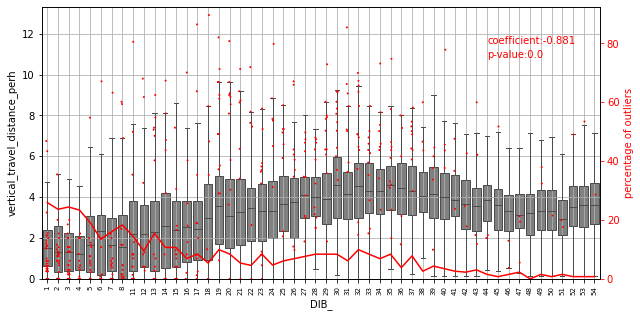

Statistics=0.897, p=0.000
Sample does not look Gaussian (reject H0)
(0.8970054388046265, 0.0002924169530160725)
Statistics=31.222, p=0.000
Sample does not look Gaussian (reject H0)
(31.221802654795532, 1.6606254749863347e-07)


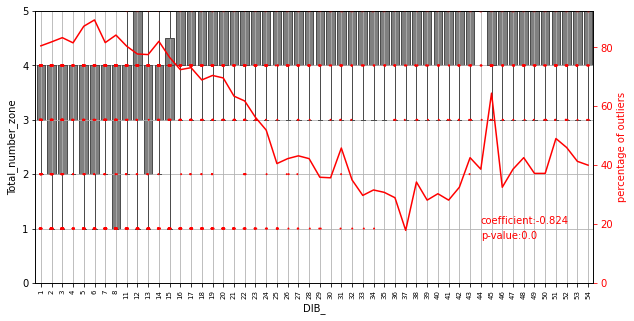

Statistics=0.868, p=0.000
Sample does not look Gaussian (reject H0)
(0.8683485388755798, 3.6962799640605226e-05)
Statistics=6.636, p=0.036
Sample does not look Gaussian (reject H0)
(6.6364635370468585, 0.03621681488093952)


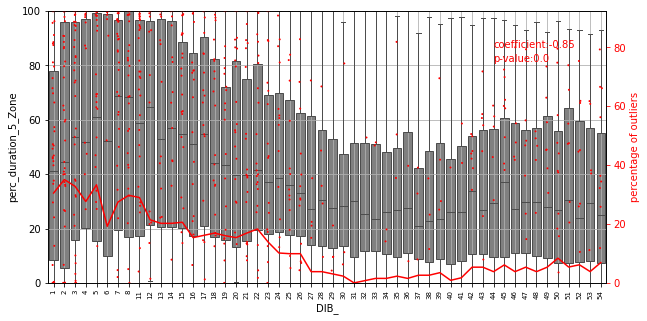

Statistics=0.950, p=0.029
Sample does not look Gaussian (reject H0)
(0.9500975608825684, 0.029401451349258423)
Statistics=3.317, p=0.190
Sample looks Gaussian (fail to reject H0)
(3.3174178554622586, 0.19038462180243398)


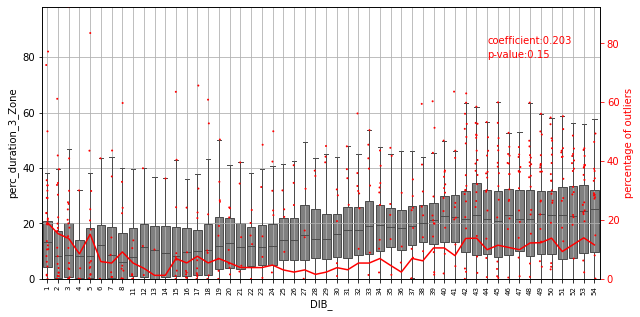

Statistics=0.703, p=0.000
Sample does not look Gaussian (reject H0)
(0.7031970024108887, 5.957824011915136e-09)
Statistics=25.054, p=0.000
Sample does not look Gaussian (reject H0)
(25.053781664736213, 3.62777577237886e-06)


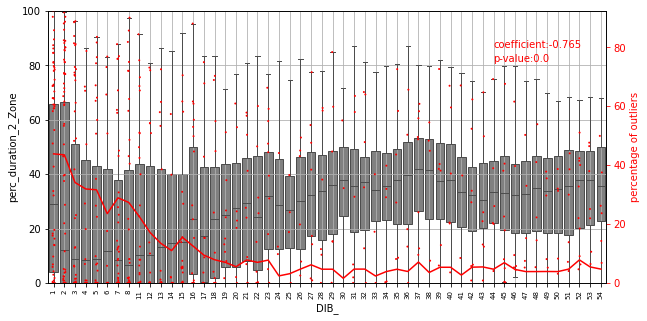

Statistics=0.956, p=0.052
Sample looks Gaussian (fail to reject H0)
(0.9559569358825684, 0.0523291751742363)
Statistics=5.801, p=0.055
Sample looks Gaussian (fail to reject H0)
(5.801439985350459, 0.05498361799930536)


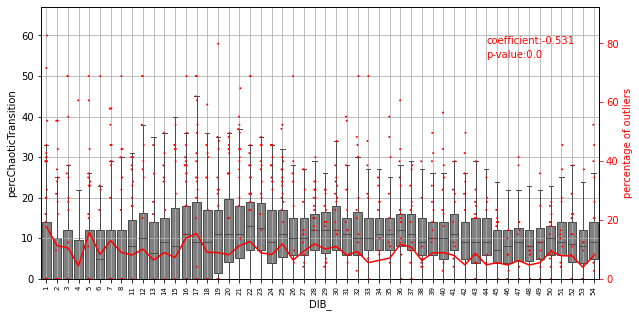

In [18]:
df_out_perc = df_outliers.groupby('DIB')[[v+'_outlier' for v in li_var]].agg(lambda x: np.nansum(list(x))/len([i for i in list(x) if not math.isnan(i)])*100).reset_index()
#small verification in case
#np.nansum([2,3,0,np.nan]), sum([2,3,0,np.nan]), len([i for i in [2,3,0,np.nan] if not math.isnan(i)])
print(df_out_perc.shape)
df_out_perc.head(3)
#works only if all str (as boxplot do this anyway)
df_outliers = df_outliers.sort_values('DIB', ascending=True)
df_out_perc = df_out_perc.sort_values('DIB', ascending=True)
df_outliers['DIB_'] = df_outliers['DIB'].map(lambda x: str(int(x)))
df_out_perc['DIB_'] = df_out_perc['DIB'].map(lambda x: str(int(x)))
order = list(df_out_perc['DIB_'].unique())
for v in li_var:
    fig, ax = plt.subplots(figsize=(10,5))
    #boxplot of values
    sns.boxplot(x='DIB_',y=v, data=df_outliers, color='grey', ax=ax, fliersize=0, linewidth=1, order=order) #does not work with boxplot :/
    plt.ylim(0,np.nanmax(df_outliers[v]))
    plt.xticks(fontsize=7,rotation=90)
    #plot the outlier observations values in red
    #order i necessary to have the point alligned ot the correct DIB
    sns.stripplot(x='DIB_',y=v, data=df_outliers[df_outliers[v+'_outlier']==True], color='red', size=2, ax=ax, order=order)
    plt.ylim(0,np.nanmax(df_outliers[v]))
    plt.xticks(fontsize=7, rotation=90)
    plt.grid()

    #percentage of outliers that day
    ax2 = ax.twinx()  
    ax2.tick_params(axis='y', colors='red')
    df_c = df_out_perc.dropna(subset=['DIB',v+'_outlier'])
    sns.lineplot(x='DIB_',y=v+'_outlier',color='red', data=df_c, ax=ax2)
    plt.ylim(0,np.nanmax(df_c[[v+'_outlier' for v in li_var]])+3)
    plt.ylabel('percentage of outliers', color='red')
    #print(ShapiroTest(df_c['DIB'].tolist()))
    #print(AgostinosK2Test(df_c['DIB'].tolist()))
    print(ShapiroTest(df_c[v+'_outlier'].tolist()))
    print(AgostinosK2Test(df_c[v+'_outlier'].tolist()))
    rcoeff2, p_value2 = pearsonr(df_c['DIB'].tolist(), df_c[v+'_outlier'].tolist())
    #rcoeff2, p_value2 = spearmanr(df_c['DIB'].tolist(), df_c[v+'_outlier'].tolist())
    if v=='Total_number_zone':
        plt.text('44', 20, 'coefficient:'+str(round(rcoeff2,3)), horizontalalignment='left', size='medium', color='red')
        plt.text('44', 15, 'p-value:'+str(round(p_value2,3)), horizontalalignment='left', size='medium', color='red')
    else:
        plt.text('44', 80, 'coefficient:'+str(round(rcoeff2,3)), horizontalalignment='left', size='medium', color='red')
        plt.text('44', 75, 'p-value:'+str(round(p_value2,3)), horizontalalignment='left', size='medium', color='red')
    
    plt.savefig(os.path.join(path_extracted_data_visual_adap,'AdaptIndicators_'+v+'.png'), bbox_inches='tight')
    plt.show();

#small verification: one visual per plot
for v in li_var:
    #boxplot of values
    sns.boxplot(x='DOA_',y=v, data=df_outliers, color='grey', fliersize=0, linewidth=1) #does not work with boxplot :/
    plt.show()
    sns.stripplot(x='DOA_',y=v, data=df_outliers[df_outliers[v+'_outlier']==True], color='red', size=3)
    plt.show()
    sns.lineplot(x='DOA_',y=v+'_outlier',color='red', data=df_out_perc)
    plt.show();

In [20]:
df_outliers.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,DIB,vertical_travel_distance_perh,Total_number_zone,perc_duration_5_Zone,perc_duration_3_Zone,perc_duration_2_Zone,percChaoticTransition,vertical_travel_distance_perh_zscore,vertical_travel_distance_perh_outlier,...,Total_number_zone_outlier,perc_duration_5_Zone_zscore,perc_duration_5_Zone_outlier,perc_duration_3_Zone_zscore,perc_duration_3_Zone_outlier,perc_duration_2_Zone_zscore,perc_duration_2_Zone_outlier,percChaoticTransition_zscore,percChaoticTransition_outlier,DIB_
0,hen_1,1.0,0.875,4.0,20.524306,12.111111,65.576389,0.0,-0.125000,False,...,False,-2.549105,False,4.082902,True,10.872244,True,NaN,NaN,1
2326,hen_109,1.0,1.250,2.0,0.000000,15.364583,84.635417,30.0,-1.153846,False,...,False,-1.948881,False,0.451107,False,4.578583,True,3.5,True,1
3394,hen_113,1.0,0.875,2.0,0.000000,21.538194,78.461806,14.0,-2.684783,False,...,True,-1.774208,False,-0.447702,False,8.439631,True,0.0,False,1


In [24]:
df_outliers['WIB'] = df_outliers['DIB'].map(lambda x: math.ceil(x/7))
df_outliers_ = df_outliers.groupby(['HenID','WIB'])[[i+'_outlier' for i in li_var]].agg(lambda x: np.nansum(list(x))/len([i for i in list(x) if not math.isnan(i)])*100).reset_index()
print(df_outliers_.shape)
display(df_outliers_.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-24-0ada6c39714a>:2: RuntimeWarning: invalid value encountered in double_scalars
  df_outliers_ = df_outliers.groupby(['HenID','WIB'])[[i+'_outlier' for i in li_var]].agg(lambda x: np.nansum(list(x))/len([i for i in list(x) if not math.isnan(i)])*100).reset_index()


(1048, 8)


,HenID,WIB,vertical_travel_distance_perh_outlier,Total_number_zone_outlier,perc_duration_5_Zone_outlier,perc_duration_3_Zone_outlier,perc_duration_2_Zone_outlier,percChaoticTransition_outlier
0,hen_1,1,0.0,0.0,0.0,50.0,75.0,NaN
1,hen_1,2,0.0,60.0,0.0,0.0,0.0,NaN
2,hen_1,3,0.0,100.0,0.0,0.0,0.0,NaN


In [26]:
df_outliers__ = pd.melt(df_outliers_, id_vars=['HenID','WIB'], value_vars=[i+'_outlier' for i in li_var])
df_outliers__

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,WIB,variable,value
0,hen_1,1,vertical_travel_distance_perh_outlier,0.000000
1,hen_1,2,vertical_travel_distance_perh_outlier,0.000000
2,hen_1,3,vertical_travel_distance_perh_outlier,0.000000
3,hen_1,4,vertical_travel_distance_perh_outlier,0.000000
4,hen_1,5,vertical_travel_distance_perh_outlier,0.000000
...,...,...,...,...
6283,hen_99,4,percChaoticTransition_outlier,28.571429
6284,hen_99,5,percChaoticTransition_outlier,28.571429
6285,hen_99,6,percChaoticTransition_outlier,28.571429
6286,hen_99,7,percChaoticTransition_outlier,0.000000


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


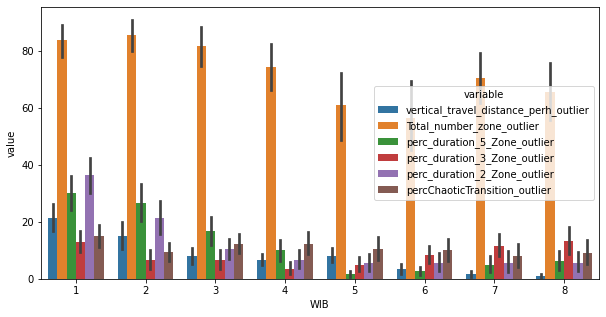

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x="WIB", y="value", hue="variable", data=df_outliers__);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


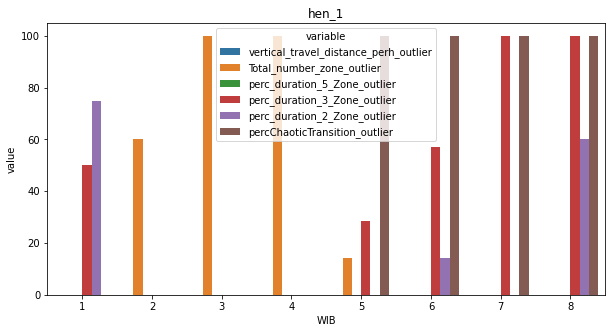

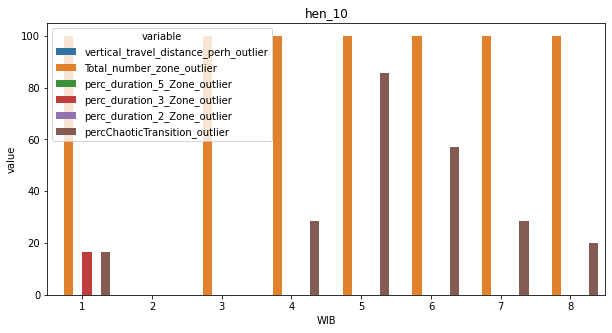

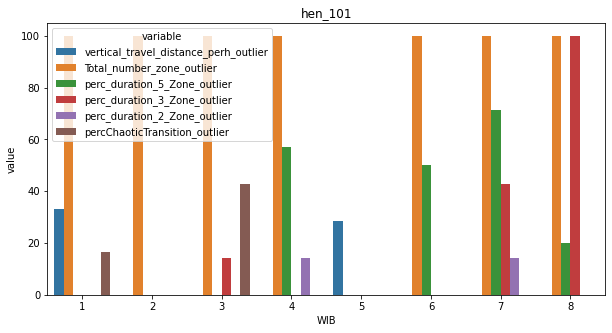

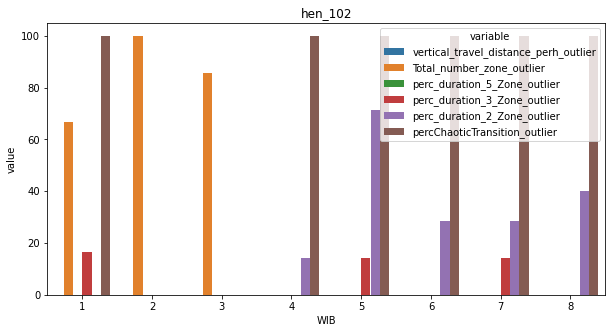

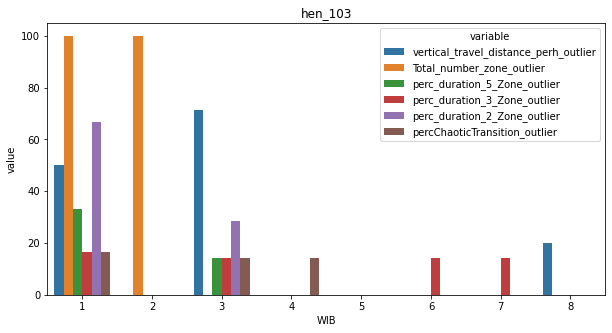

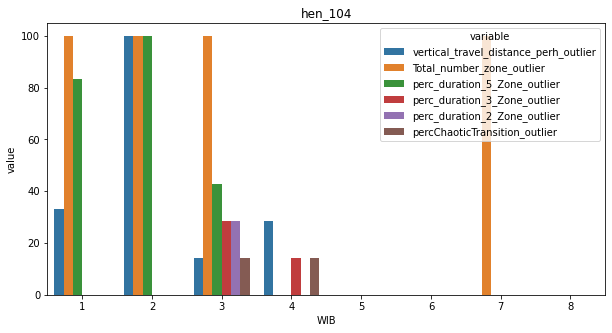

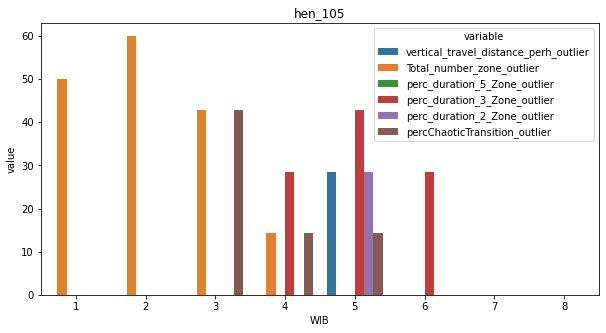

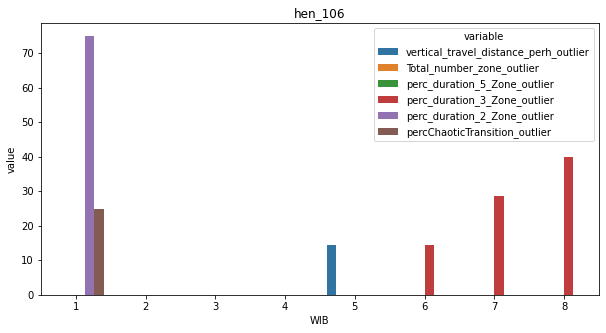

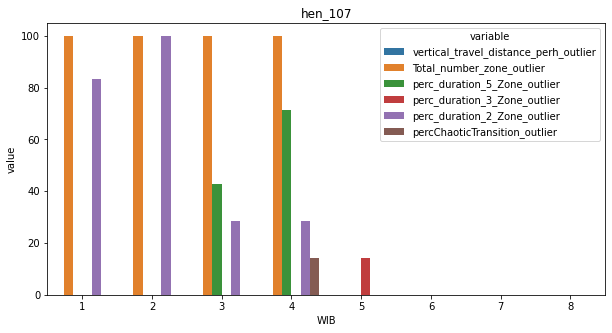

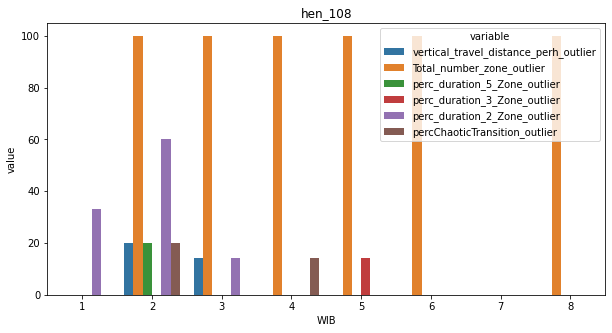

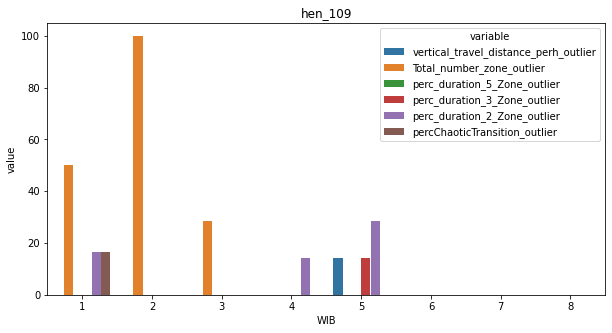

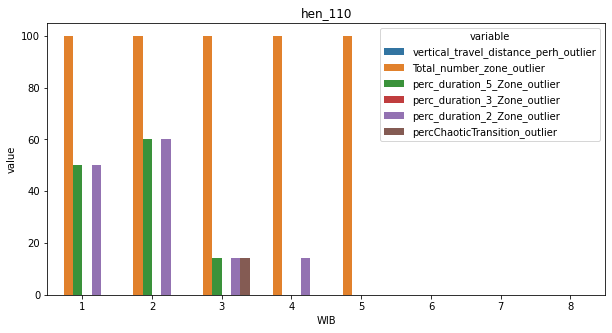

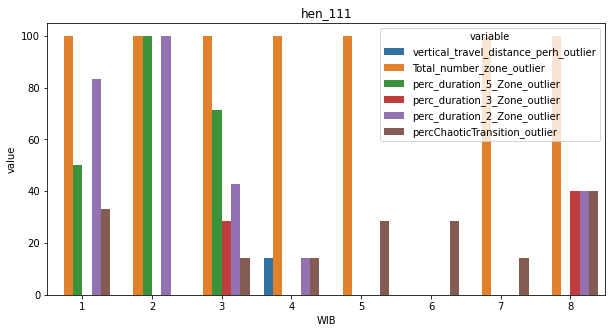

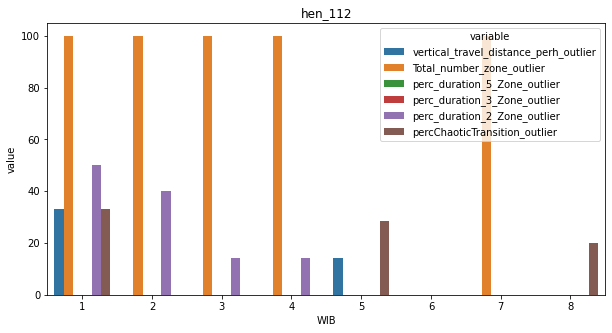

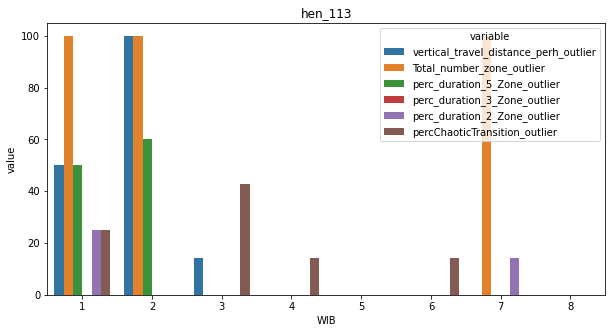

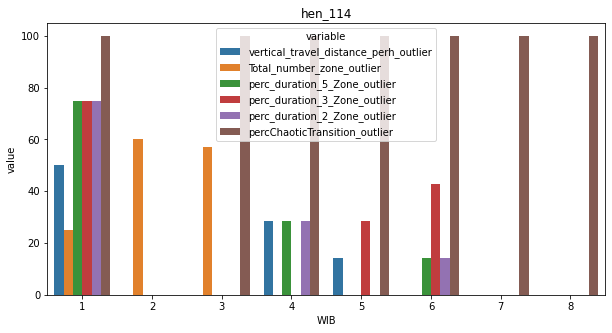

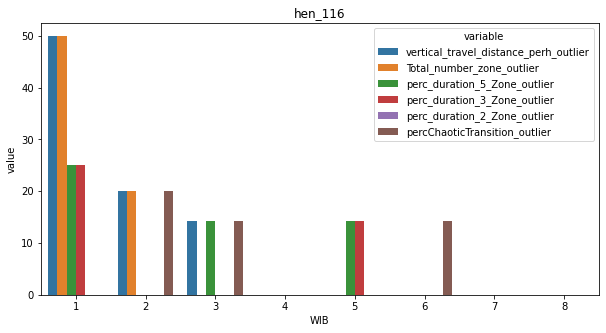

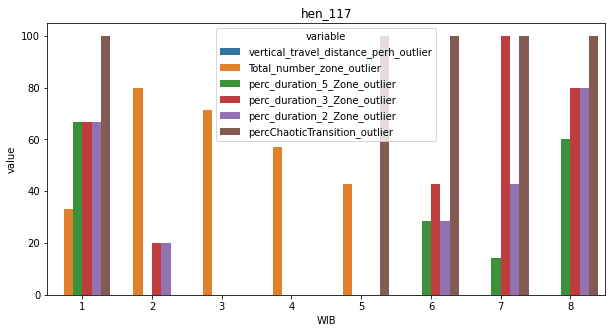

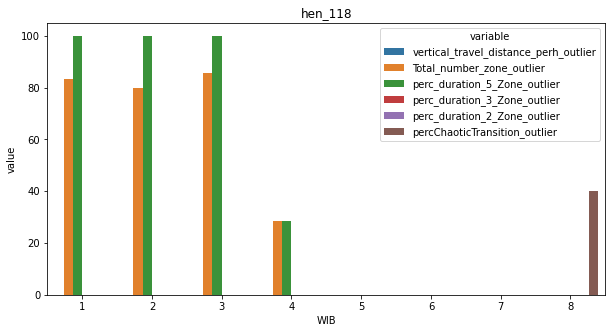

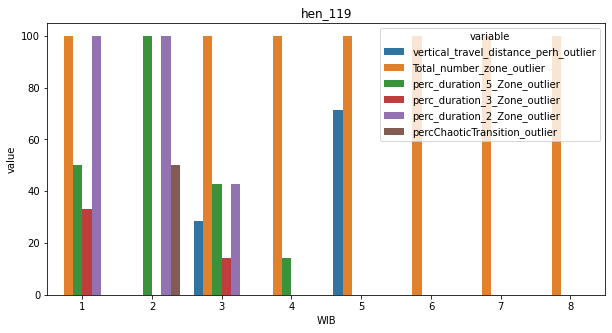

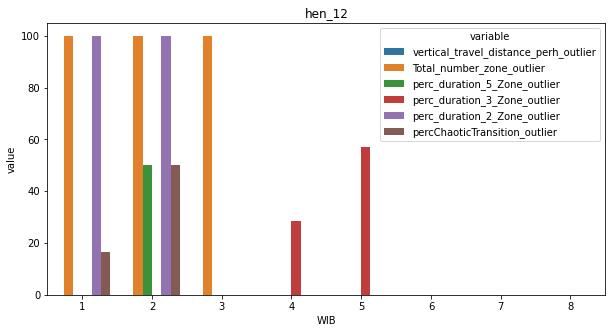

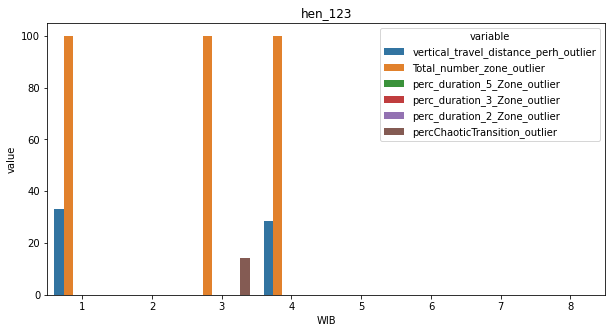

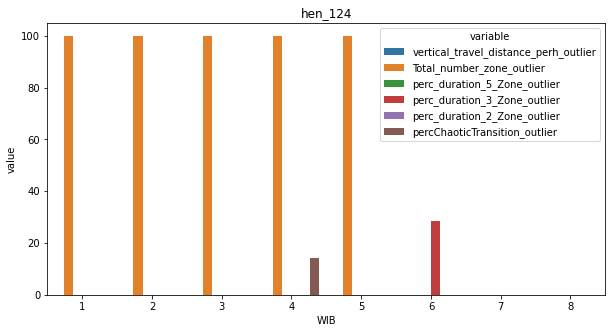

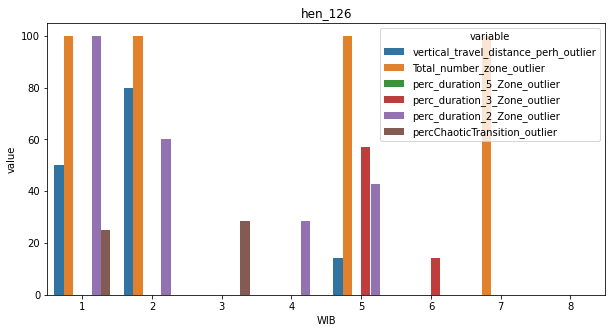

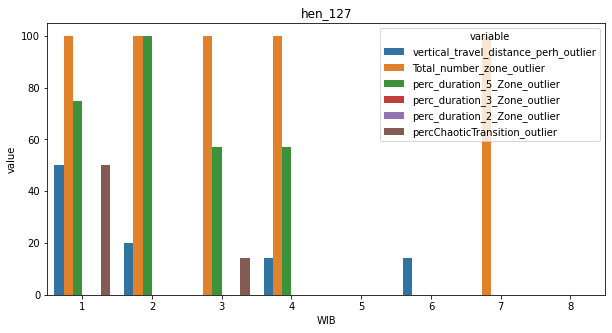

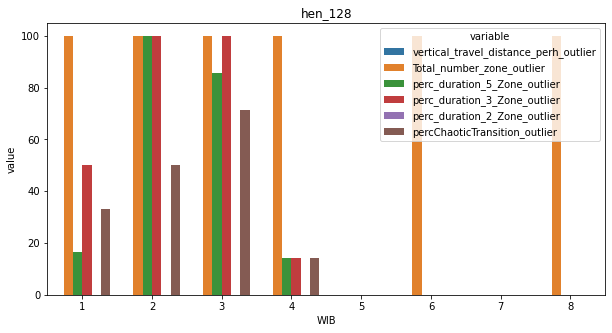

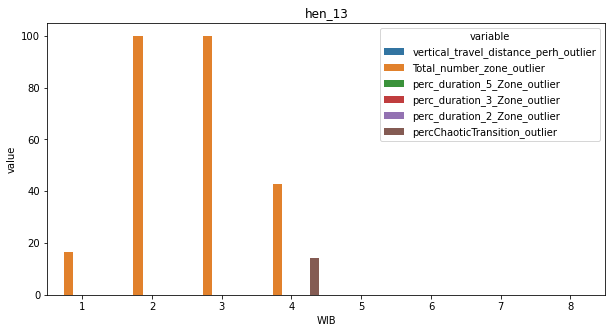

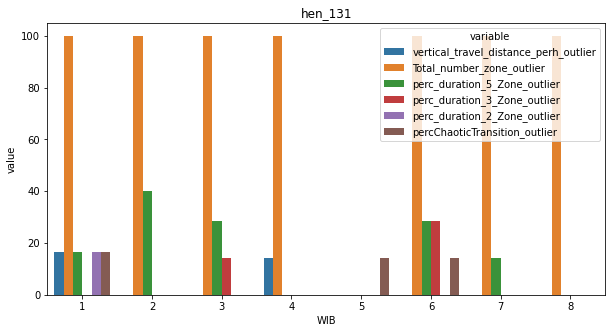

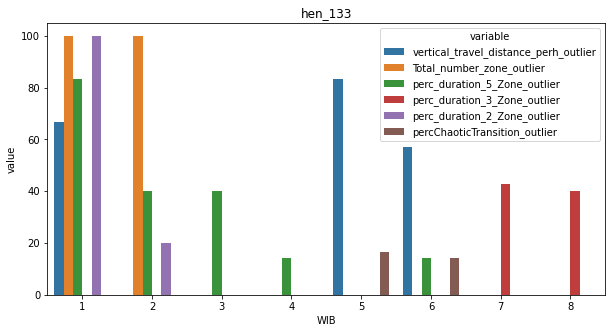

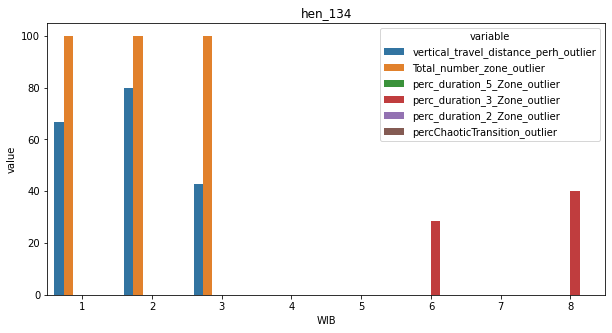

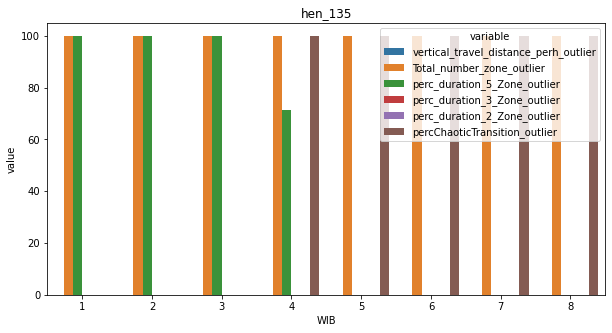

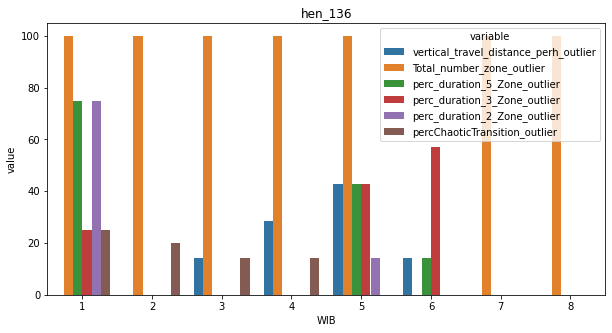

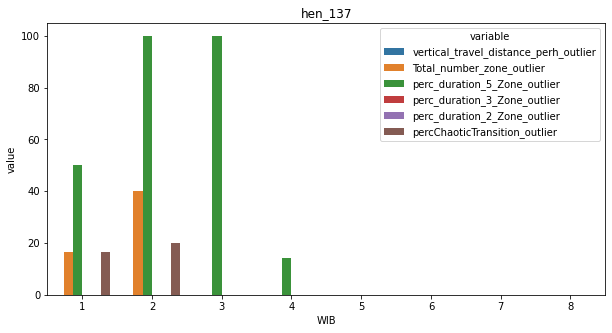

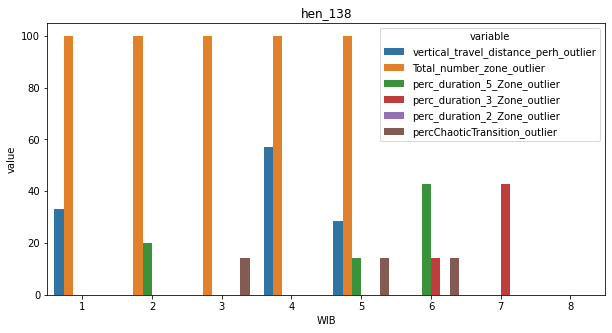

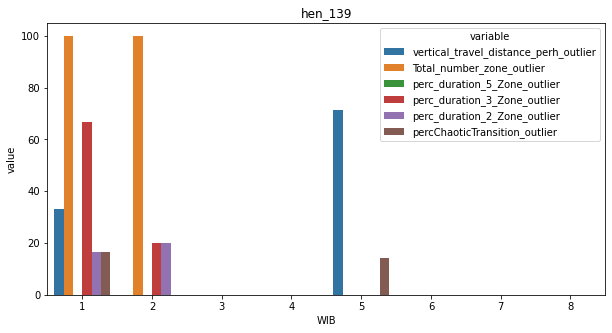

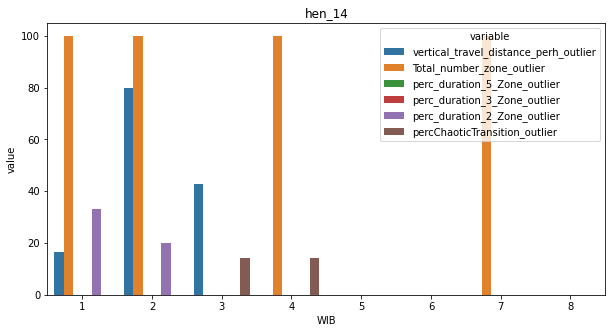

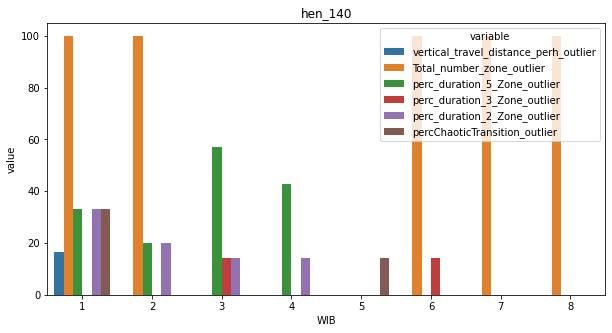

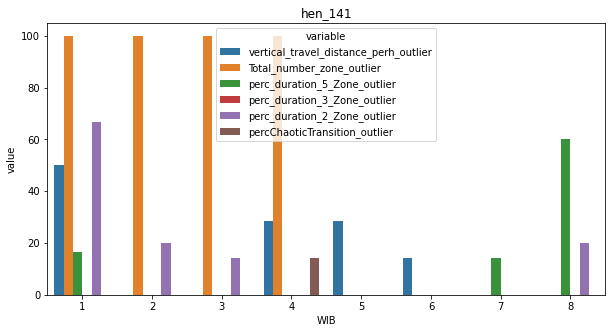

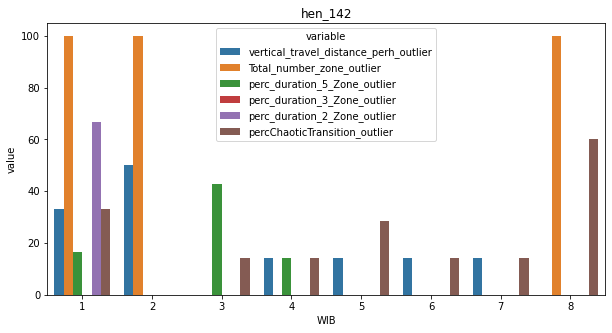

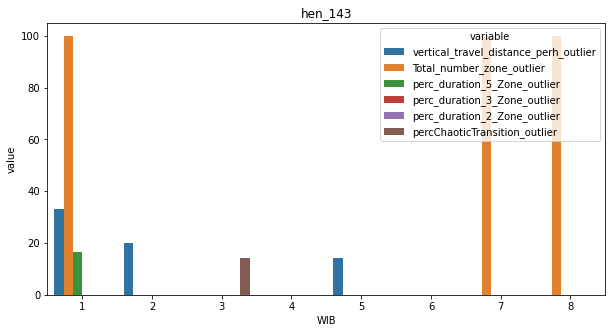

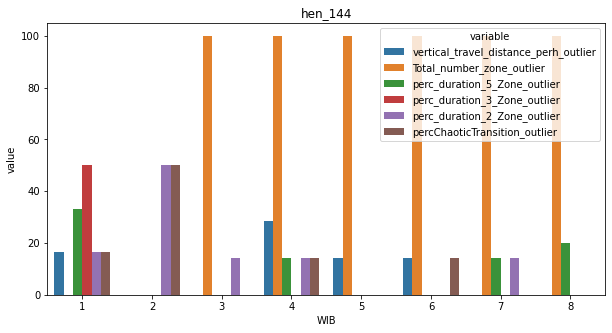

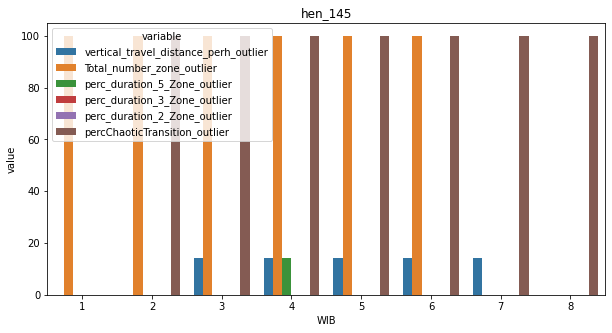

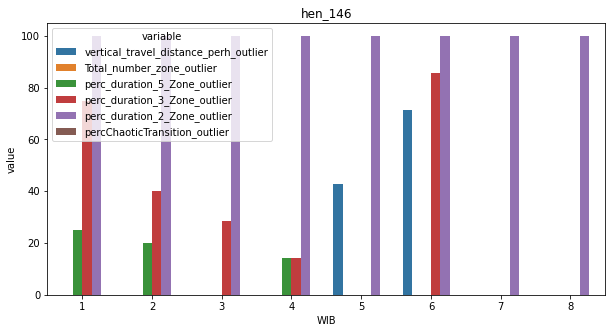

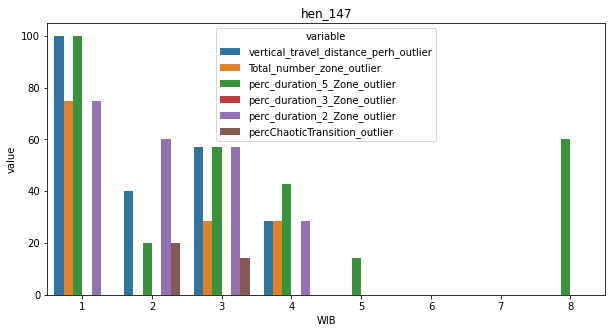

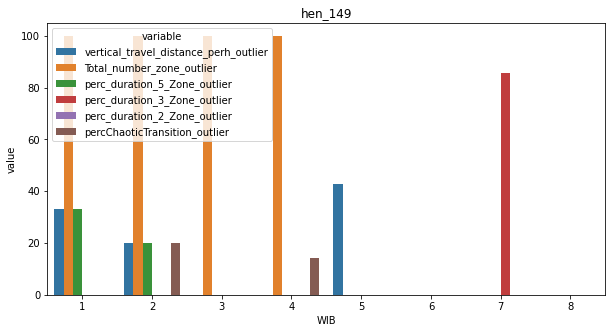

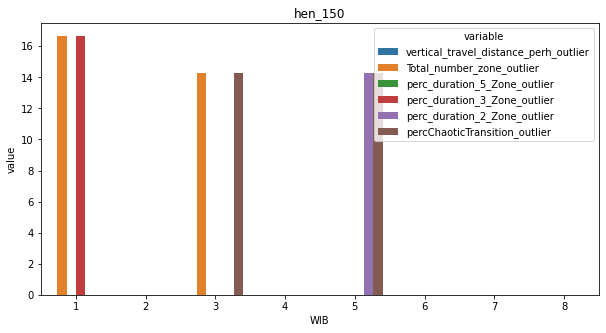

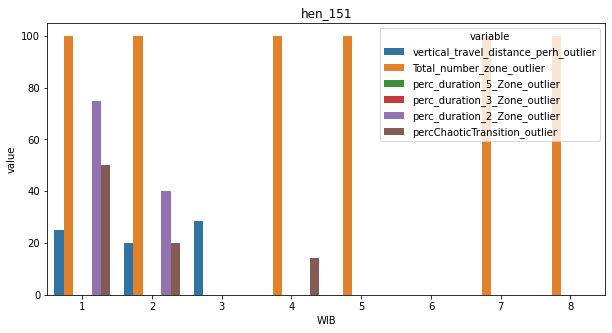

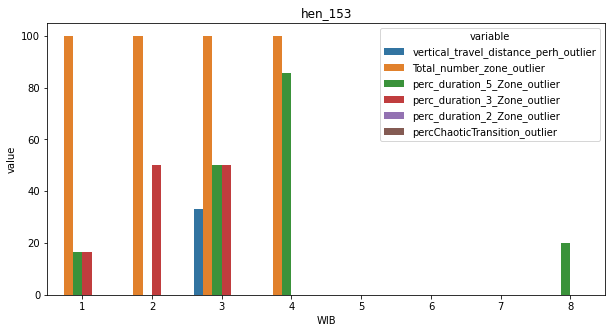

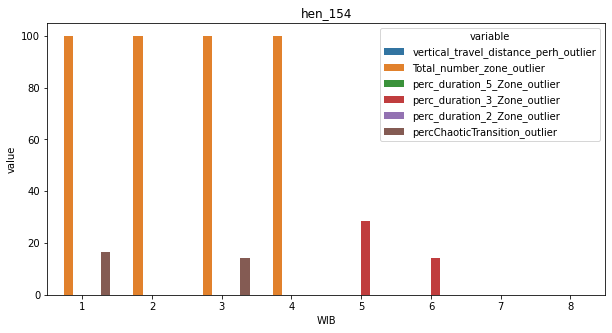

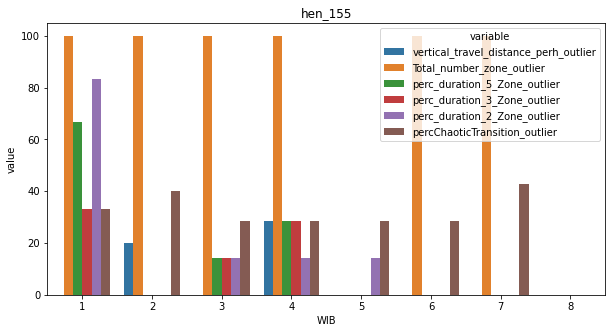

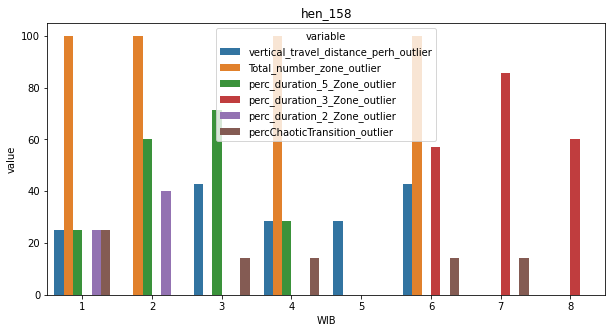

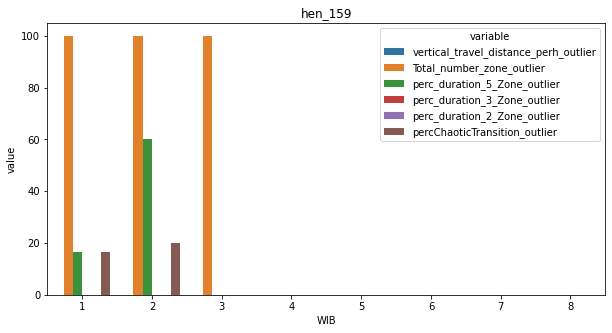

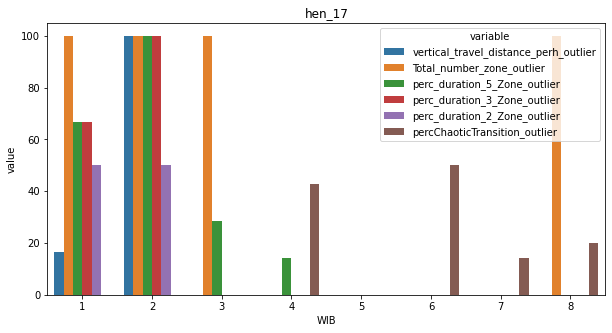

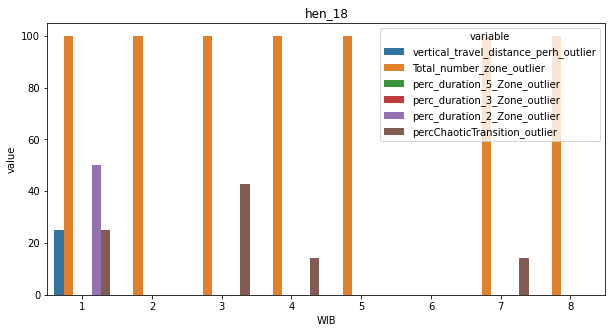

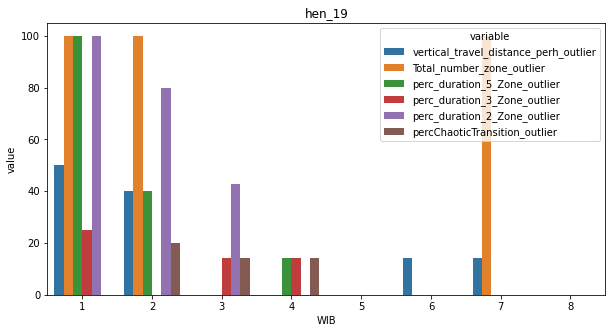

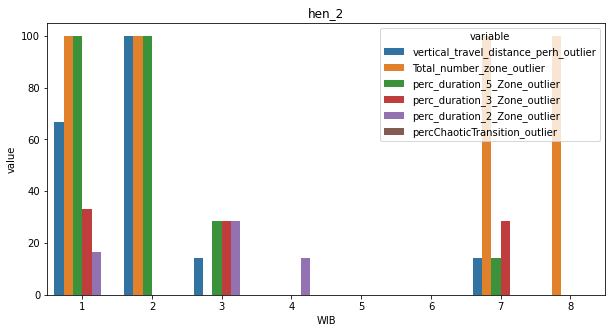

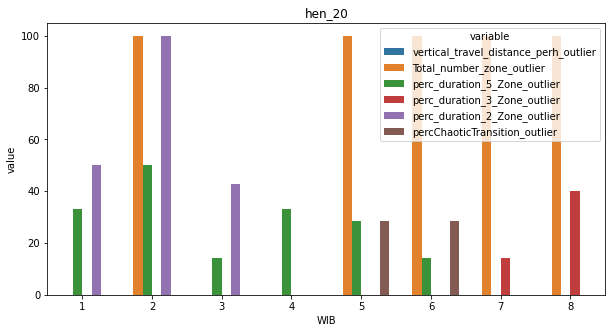

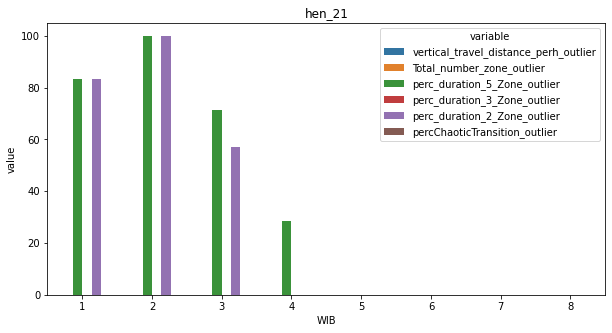

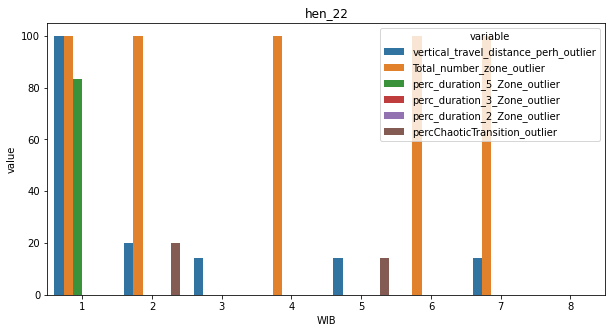

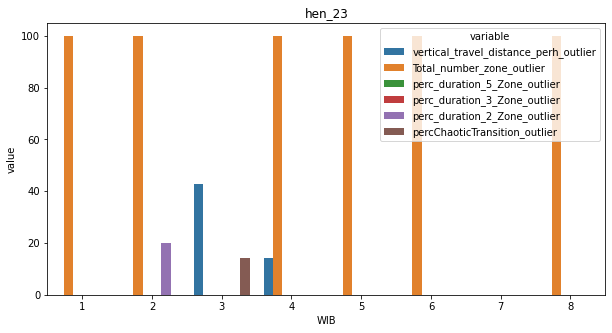

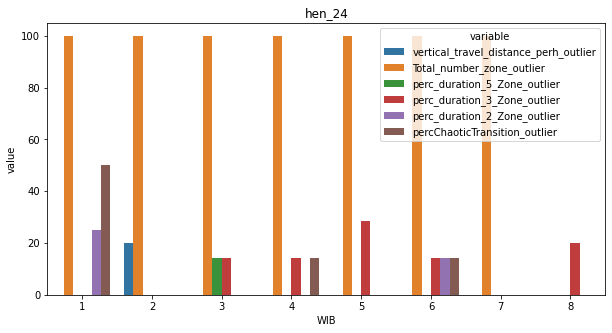

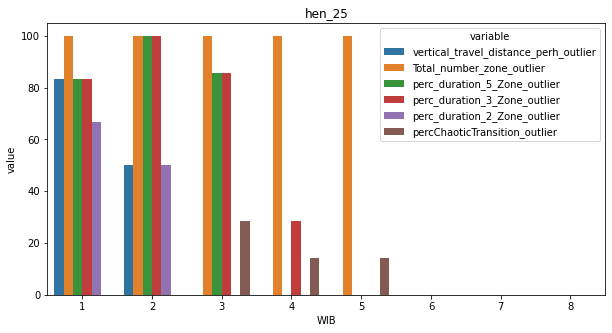

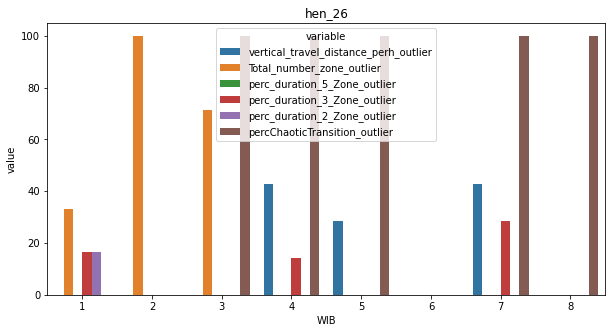

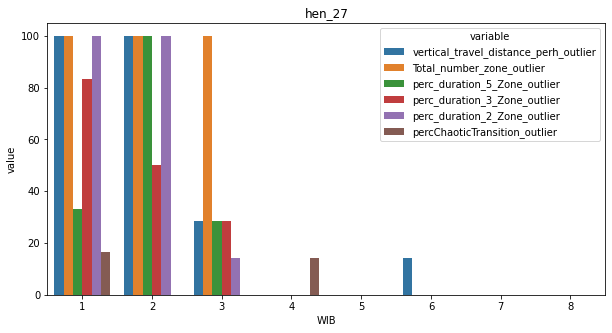

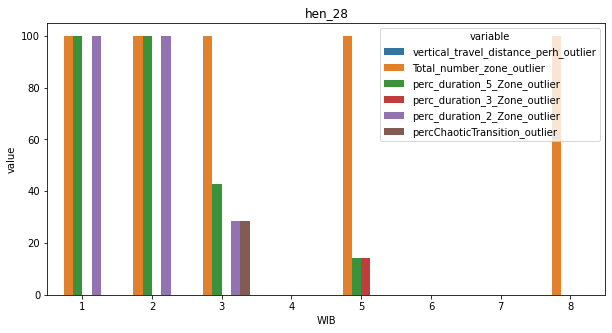

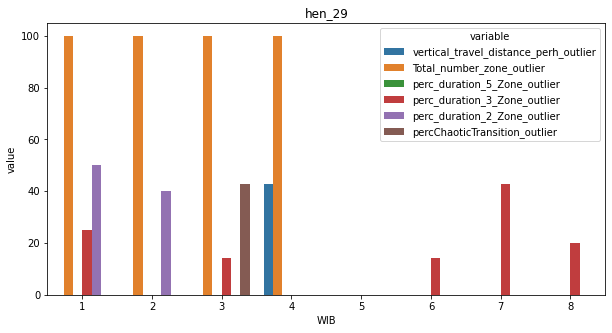

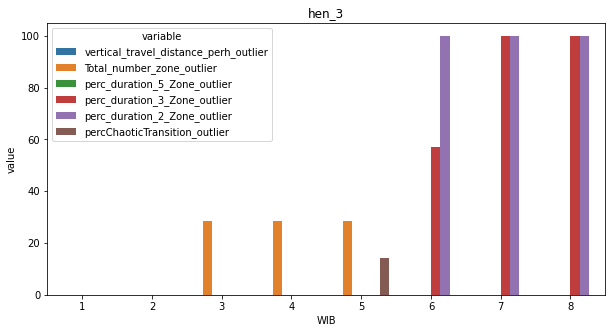

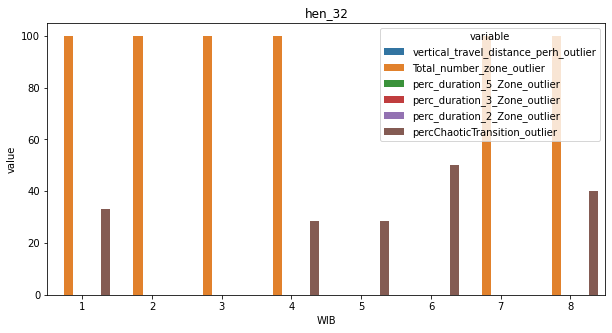

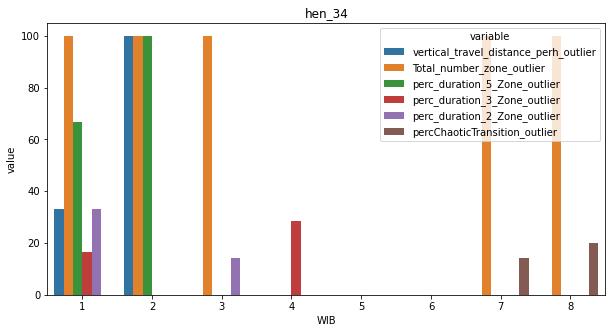

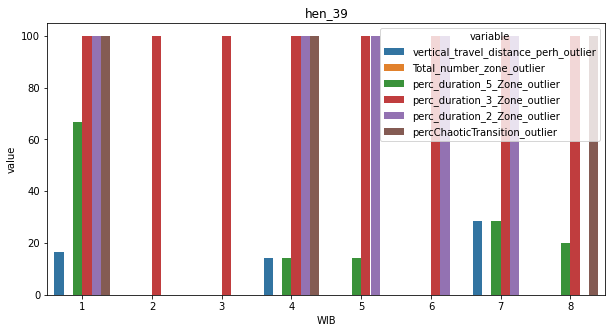

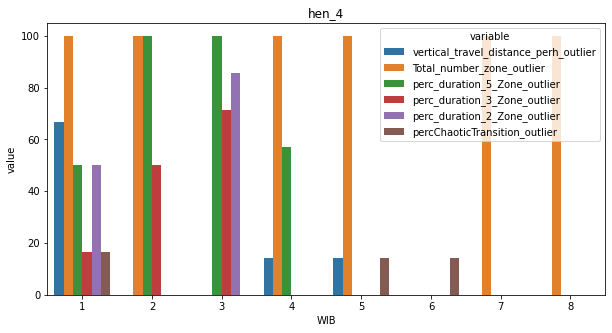

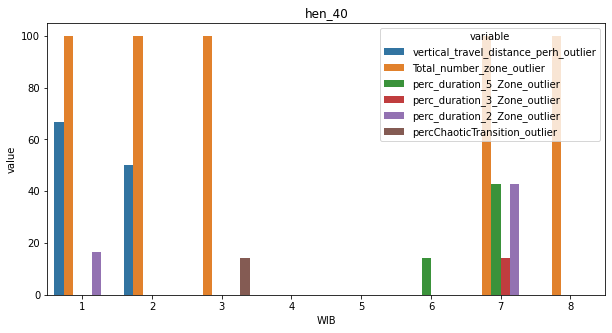

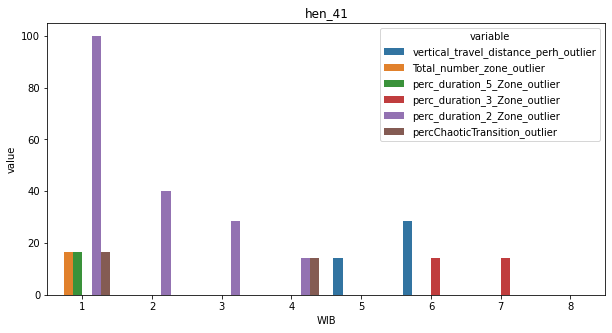

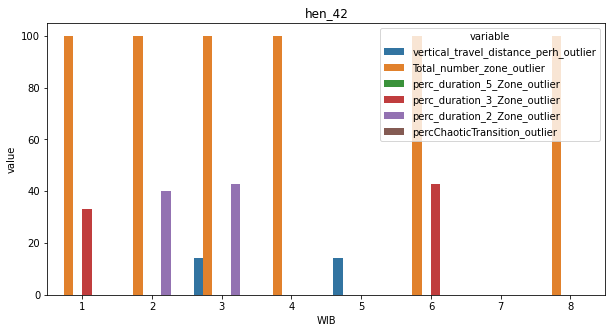

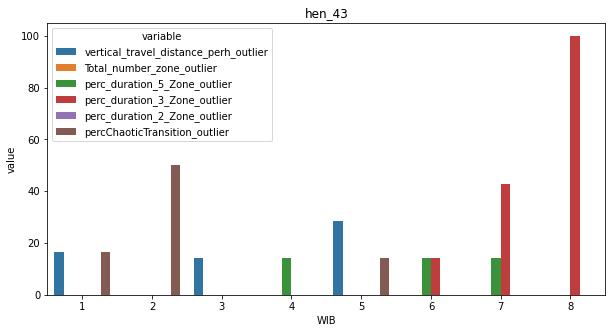

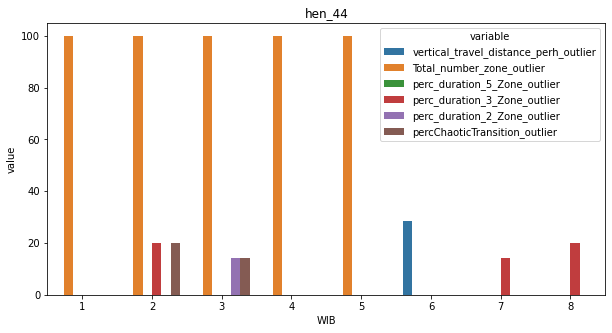

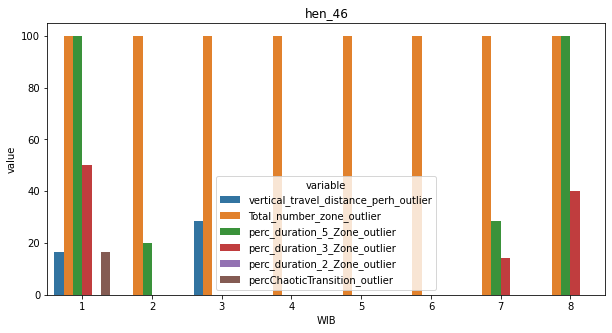

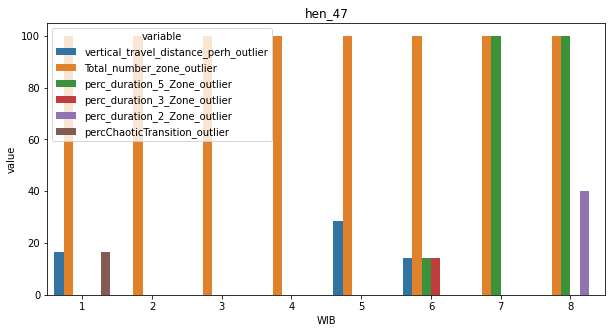

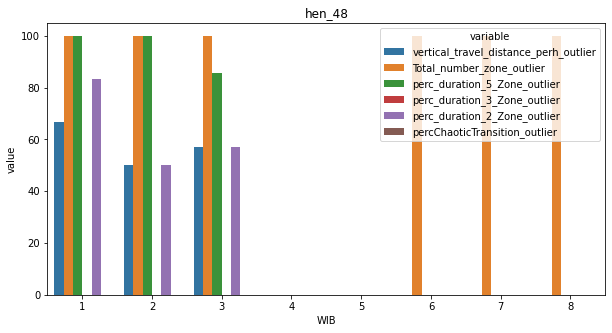

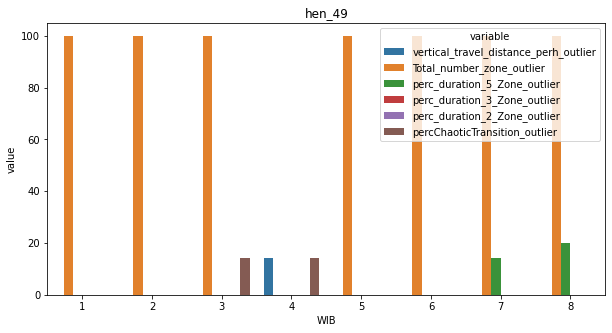

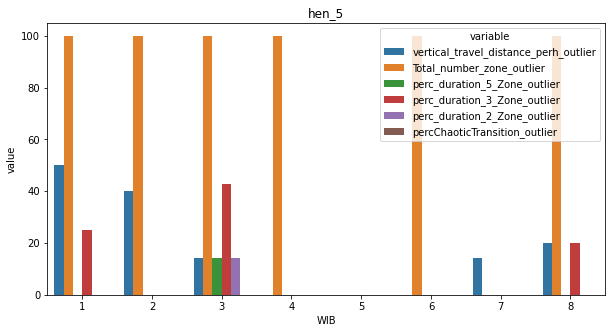

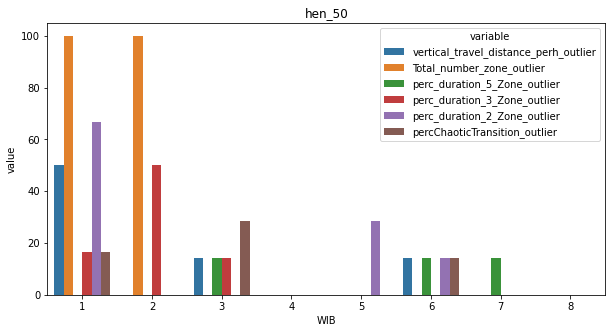

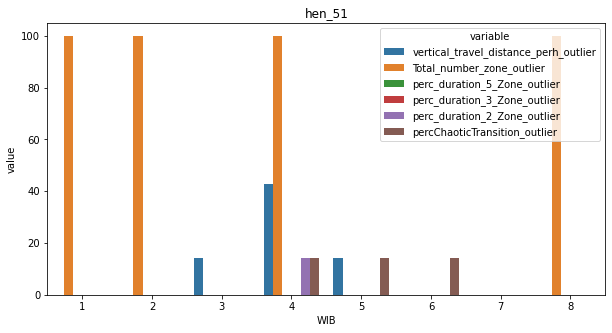

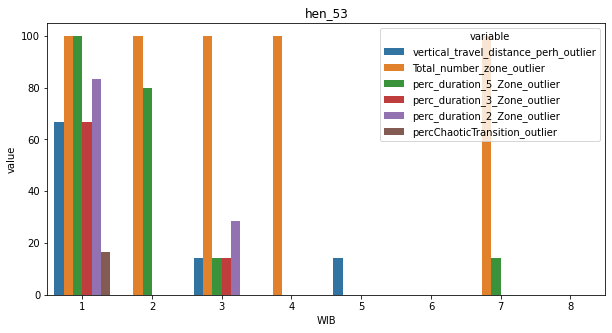

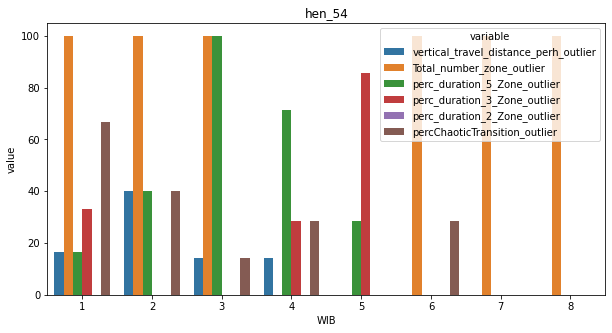

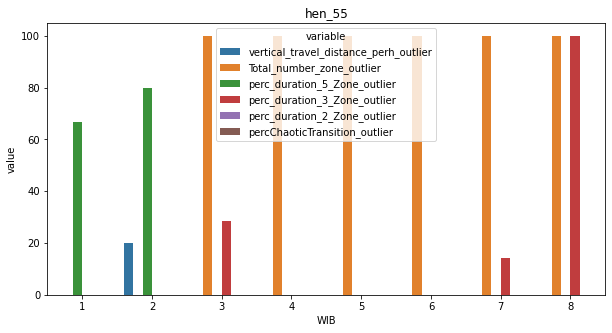

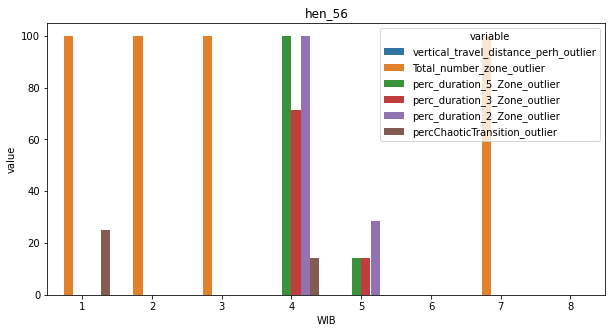

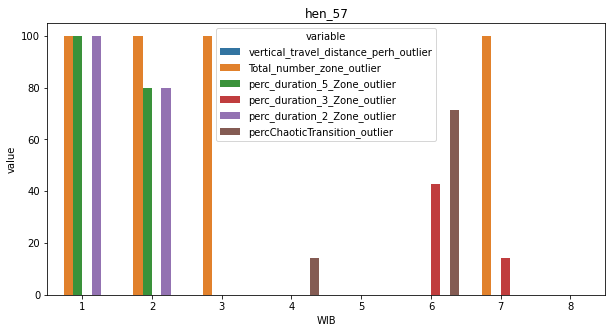

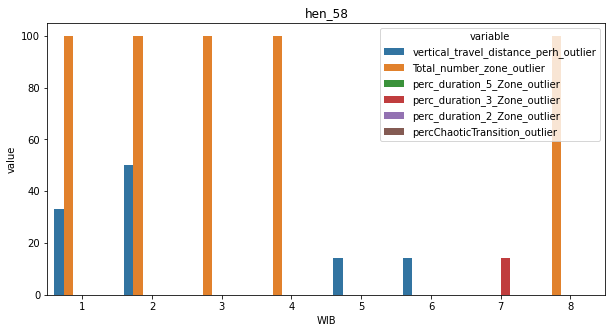

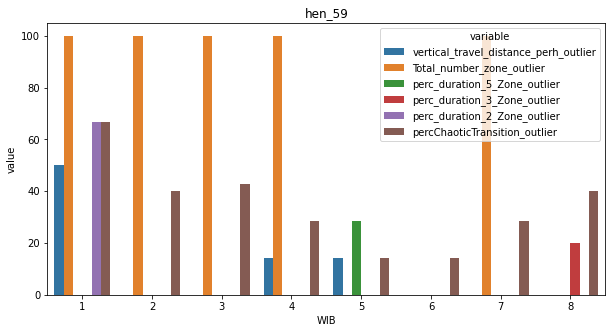

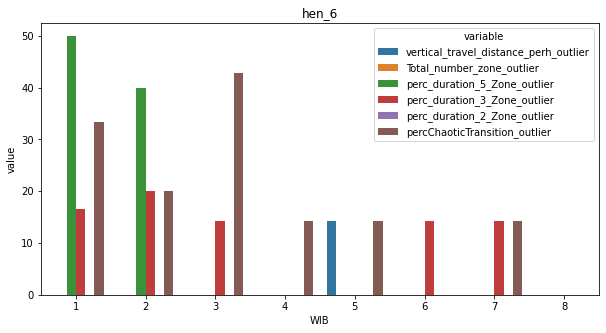

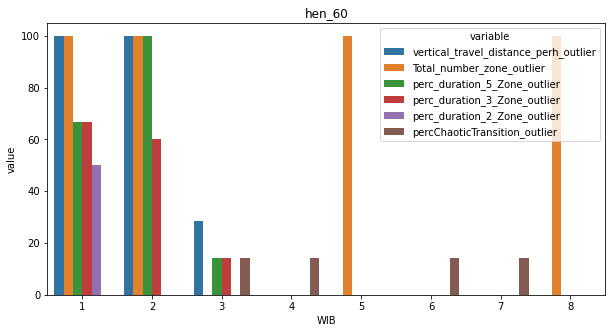

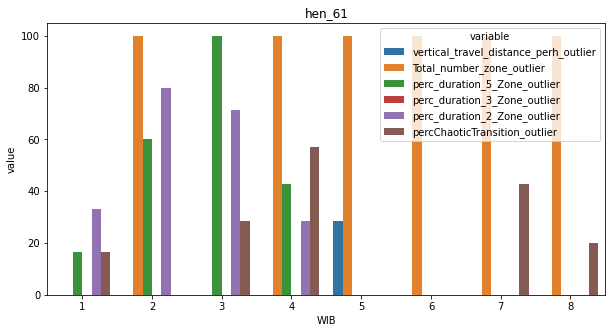

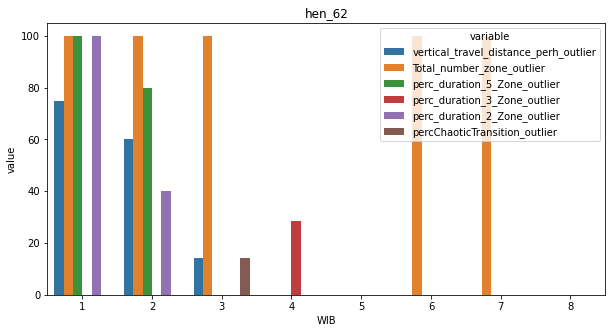

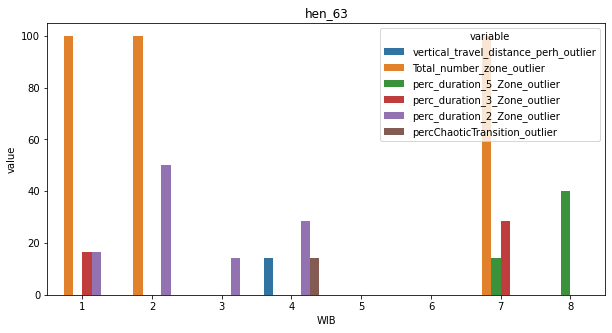

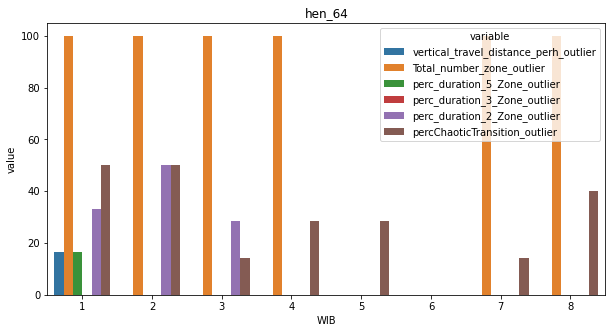

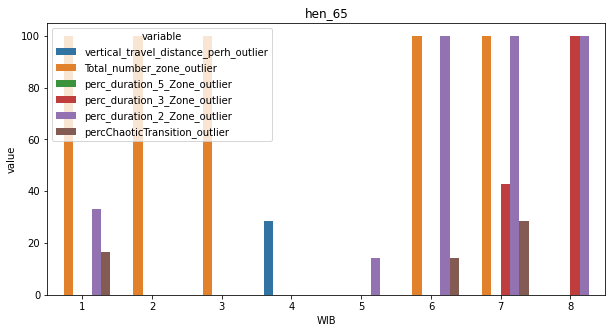

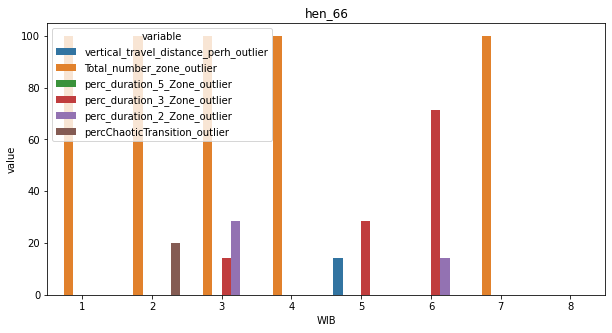

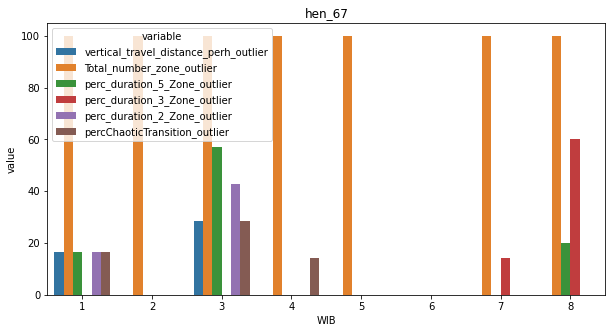

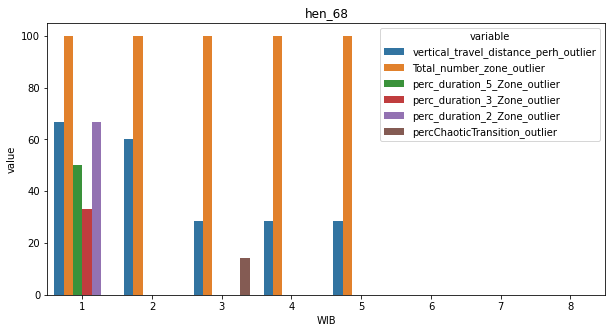

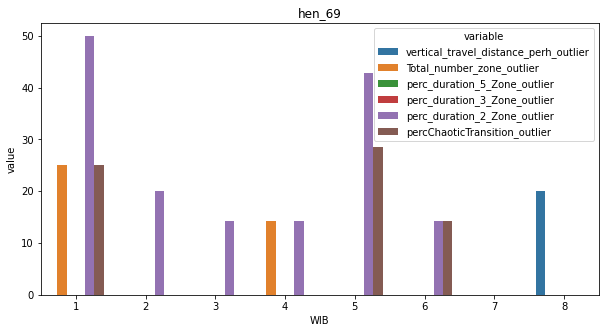

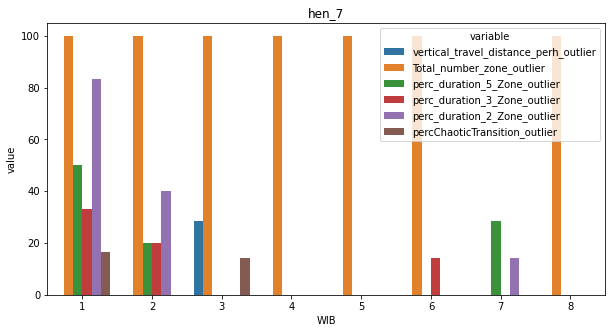

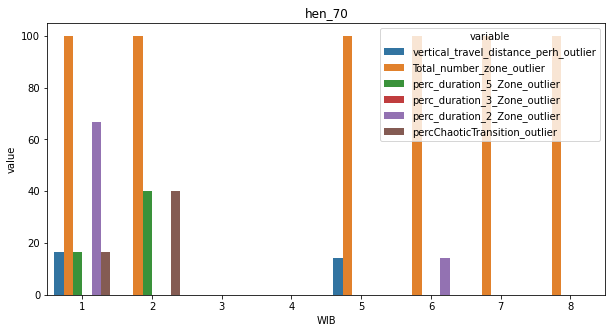

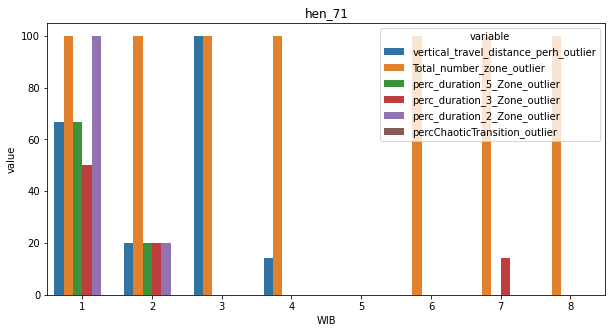

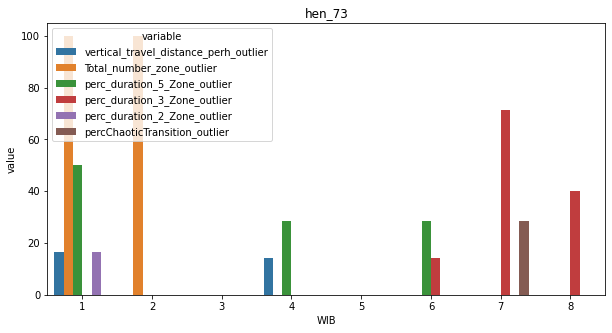

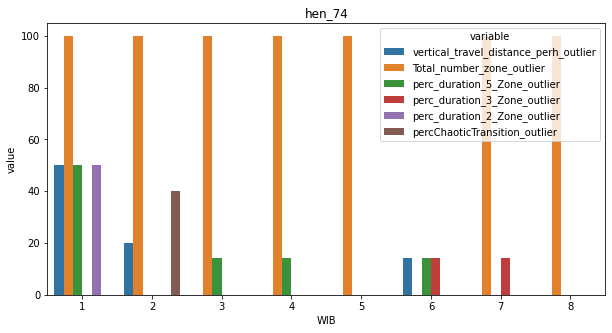

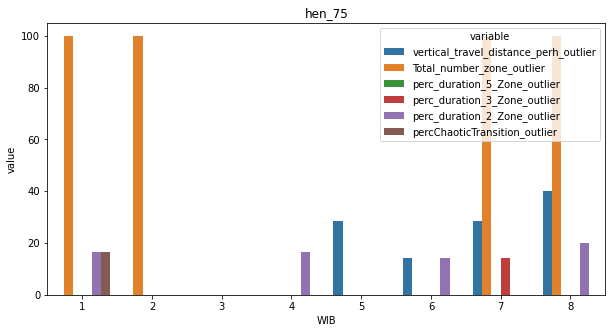

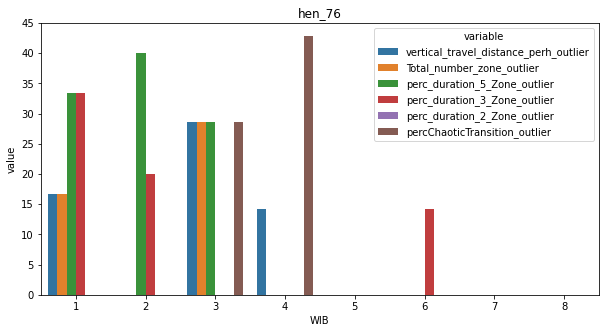

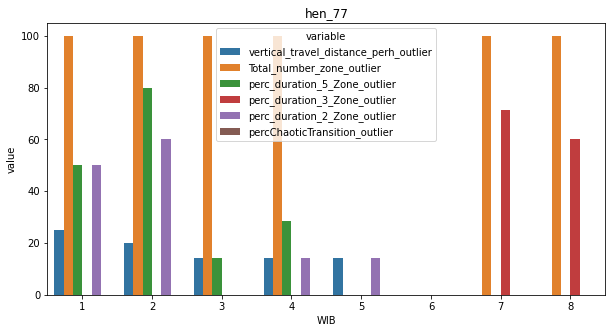

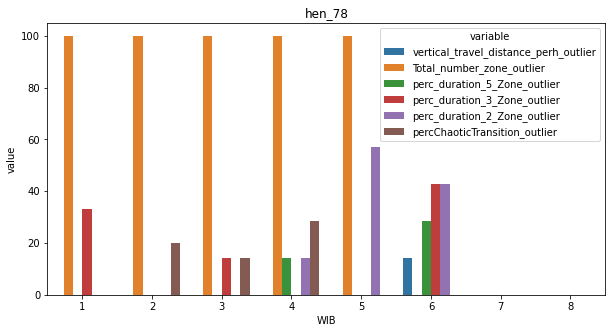

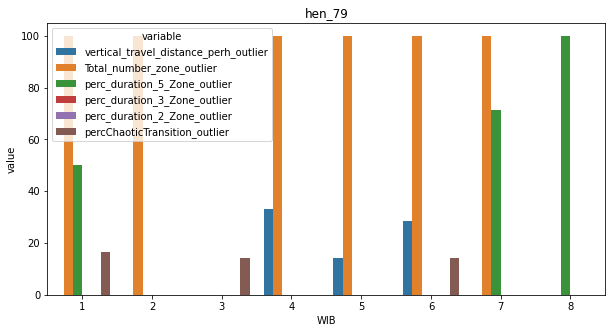

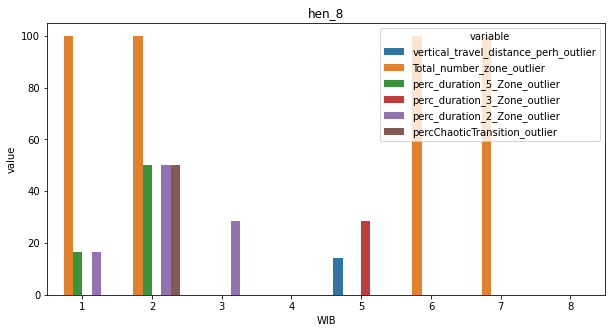

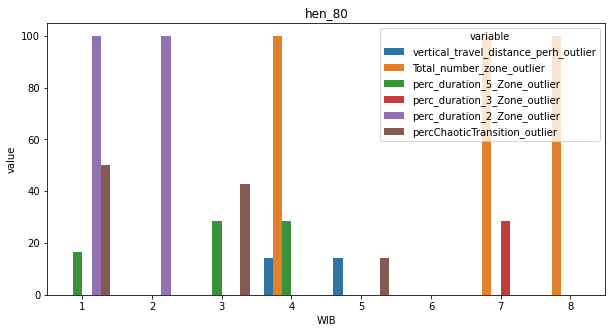

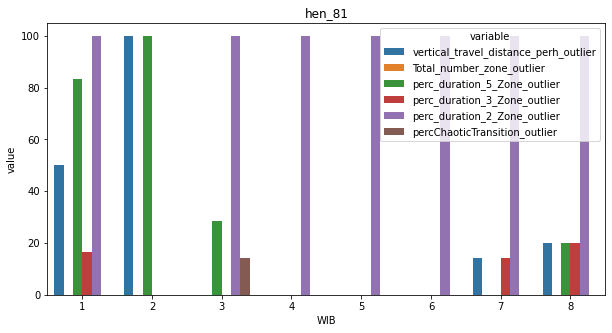

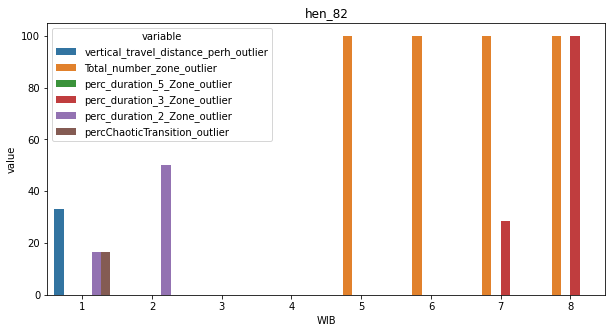

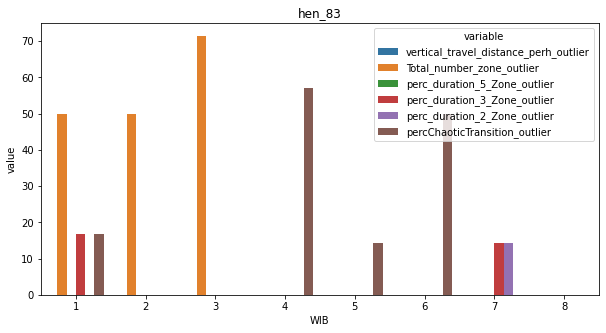

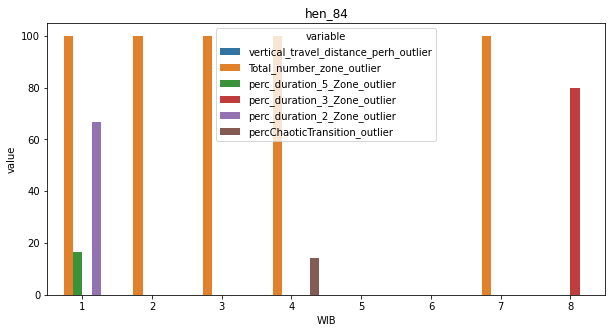

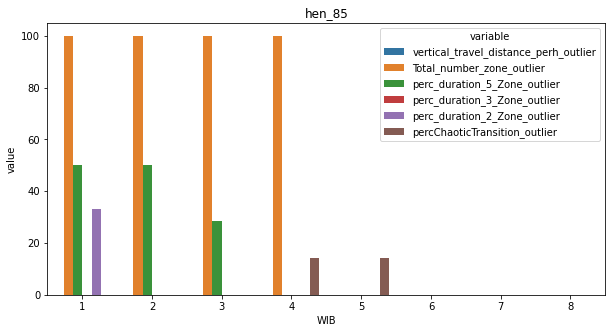

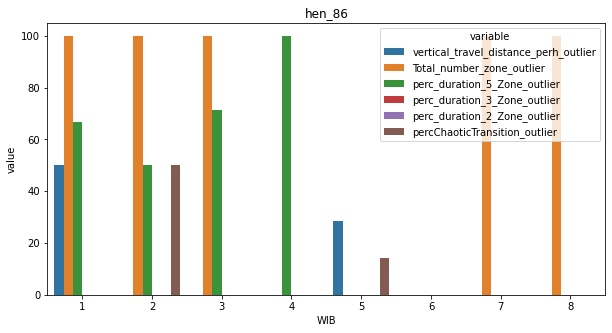

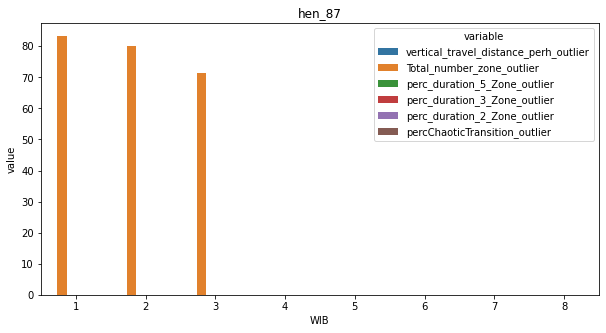

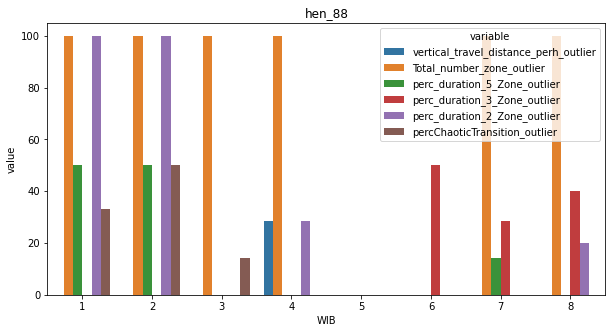

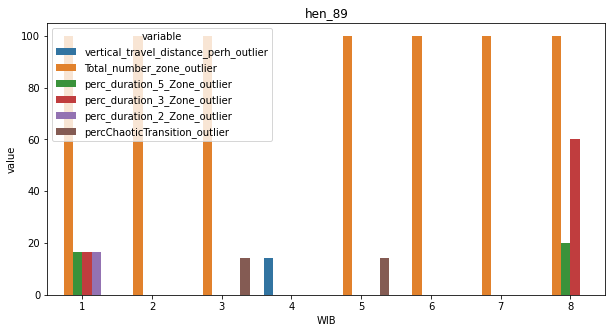

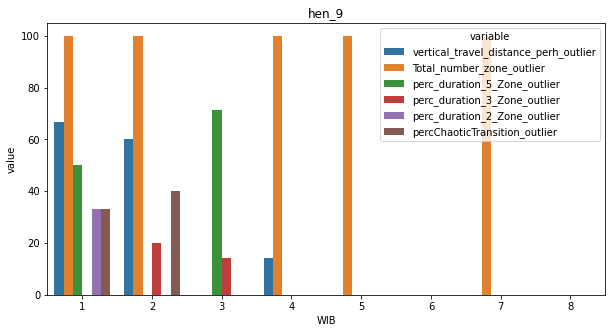

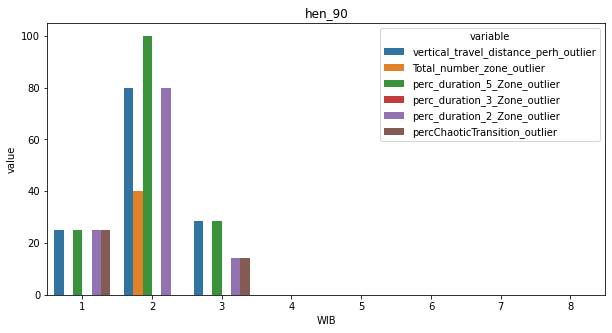

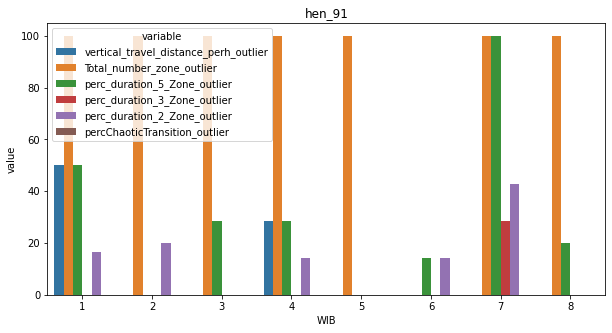

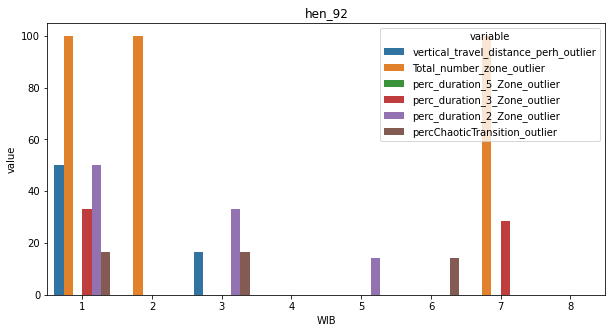

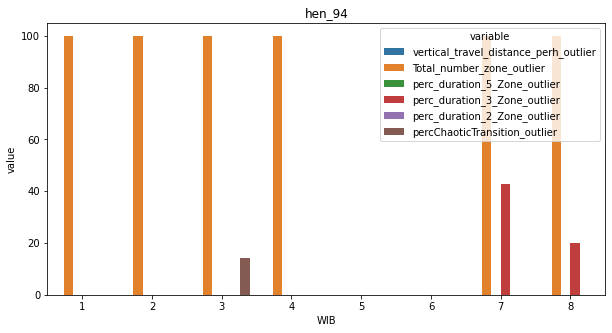

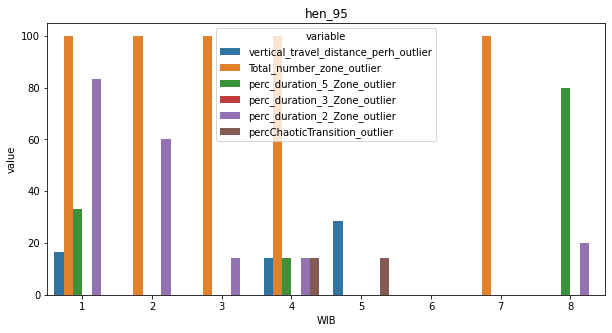

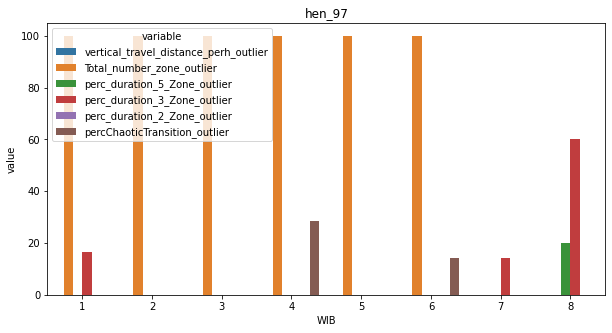

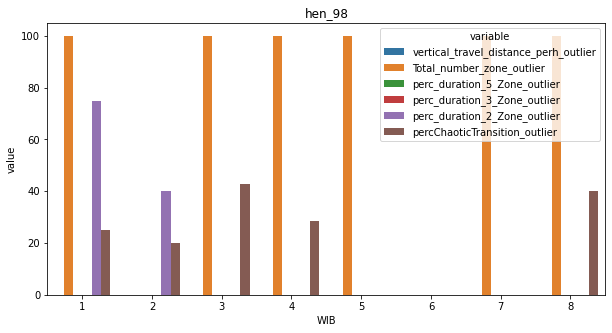

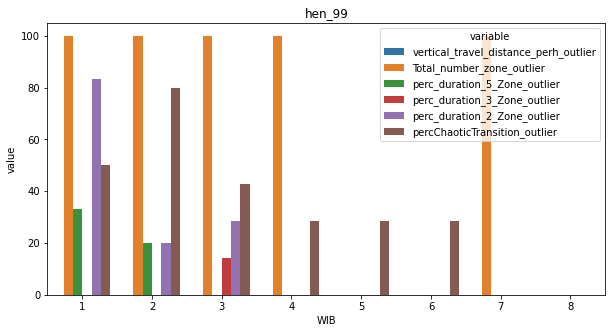

In [37]:
#By curiosity
for henid,df_ in df_outliers__.groupby(['HenID']):
    plt.figure(figsize=(10,5))
    sns.barplot(x="WIB", y="value", hue="variable", data=df_)
    plt.title(henid)
    plt.show()